In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
no_task_loss_prog_df = pd.read_csv('./loss_progression_no_tasks.csv', index_col=0)
no_task_train_prediction_df = pd.read_csv('./util_lstm_train_no_tasks.csv', index_col=0)
no_task_test_prediction_df = pd.read_csv('./util_lstm_test_no_tasks.csv', index_col=0)

In [3]:
no_task_loss_prog_df.rename(columns={'0': 'loss progress - no tasks'}, inplace=True)
no_task_loss_prog_df.head()

,loss progress - no tasks
0,0.067000
1,0.097104
2,0.096889
3,0.009040
4,0.016942


In [4]:
with_task_loss_prog_df = pd.read_csv('./loss_progression_with_tasks.csv', index_col=0)
with_task_train_prediction_df = pd.read_csv('./util_lstm_train_with_tasks.csv', index_col=0)
with_task_test_prediction_df = pd.read_csv('./util_lstm_test_with_tasks.csv', index_col=0)

In [5]:
with_task_loss_prog_df.rename(columns={'0': 'loss progress - with tasks'}, inplace=True)

In [6]:
cycler = plt.cycler(linestyle=['-', '-', '-', '-.', '--', '-', '--'],
                    color=['black', 'blue', 'green', 'grey', 'green', 'black', 'green'],
)

def plot_df(df: pd.DataFrame, df_columns: list = None, start_range: int = -1, end_range: int = -1, save_plot_path: str = None, y_label: str = ''):  # type: ignore
    if df_columns is None or len(df_columns) == 0:
        df_columns = df.columns.to_list()
    if start_range == -1:
        start_range = 0
    if end_range == -1:
        end_range = len(df)
    fig, ax = plt.subplots()
    
    plt.xlabel('time step', fontsize=45)
    plt.ylabel(y_label, fontsize=45)
    
    ax.set_prop_cycle(cycler)
    plot = df[df_columns].iloc[start_range:end_range].plot.line(figsize=(25, 20), linewidth=4, fontsize=40, ax=ax)
    plt.legend(fontsize=40)
    if save_plot_path is not None:
        plot.figure.savefig(save_plot_path)


In [7]:
comp_loss_prog_df = pd.merge(left=no_task_loss_prog_df, right=with_task_loss_prog_df, left_index=True, right_index=True)

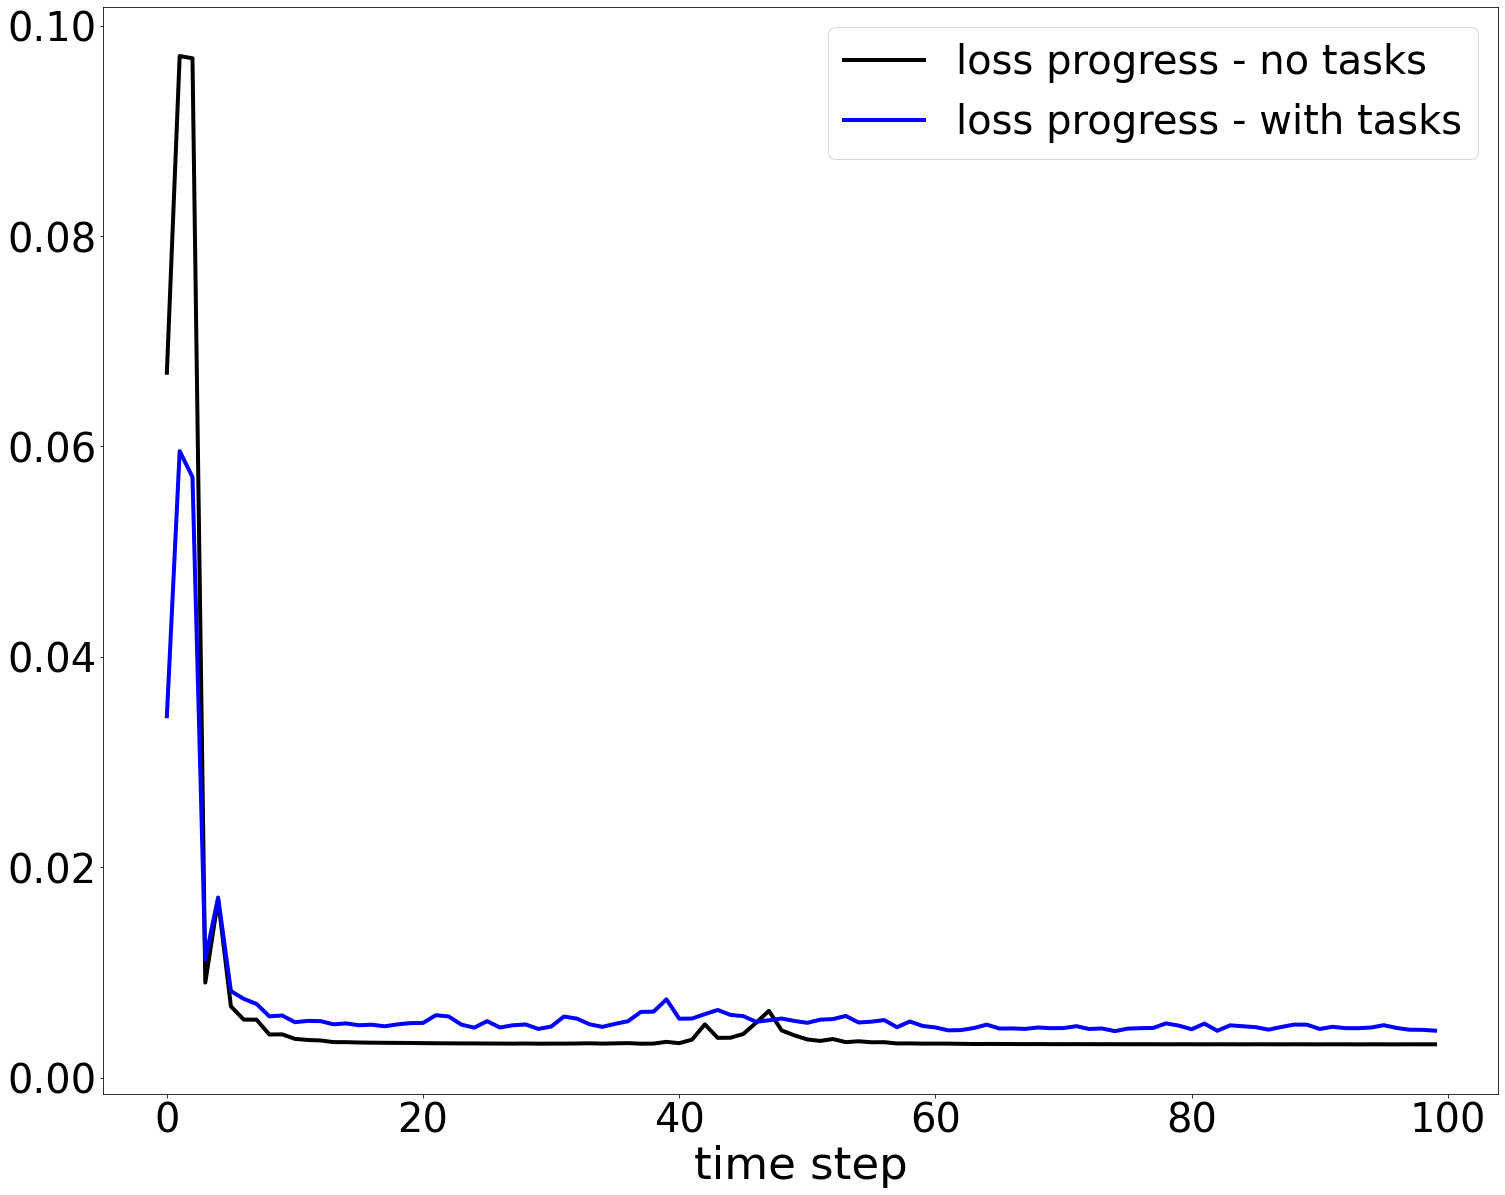

In [8]:
plot_df(comp_loss_prog_df)

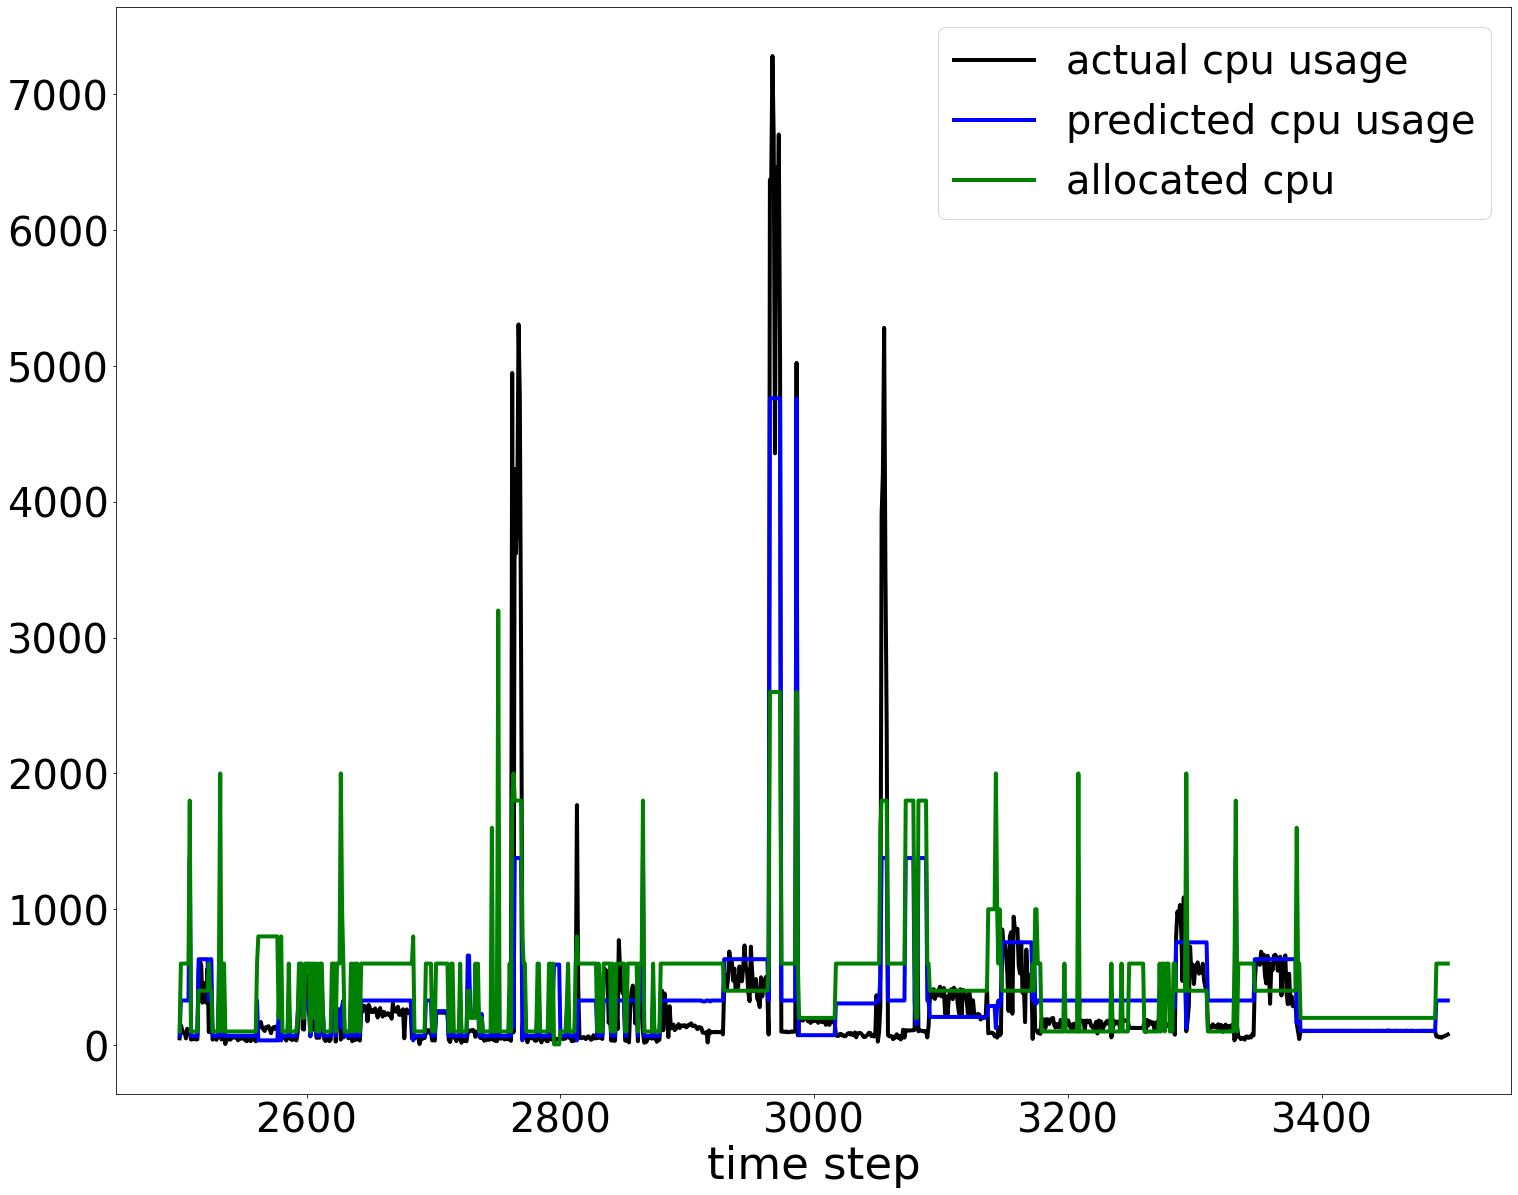

In [9]:
plot_df(no_task_train_prediction_df, df_columns=['actual cpu usage', 'predicted cpu usage', 'allocated cpu'], start_range=2500, end_range=3500)

In [10]:
no_task_train_prediction_df.columns

Index(['actual cpu usage', 'actual mem usage', 'predicted cpu usage',
       'predicted mem usage', 'allocated cpu', 'allocated mem'],
      dtype='object')

<AxesSubplot:>

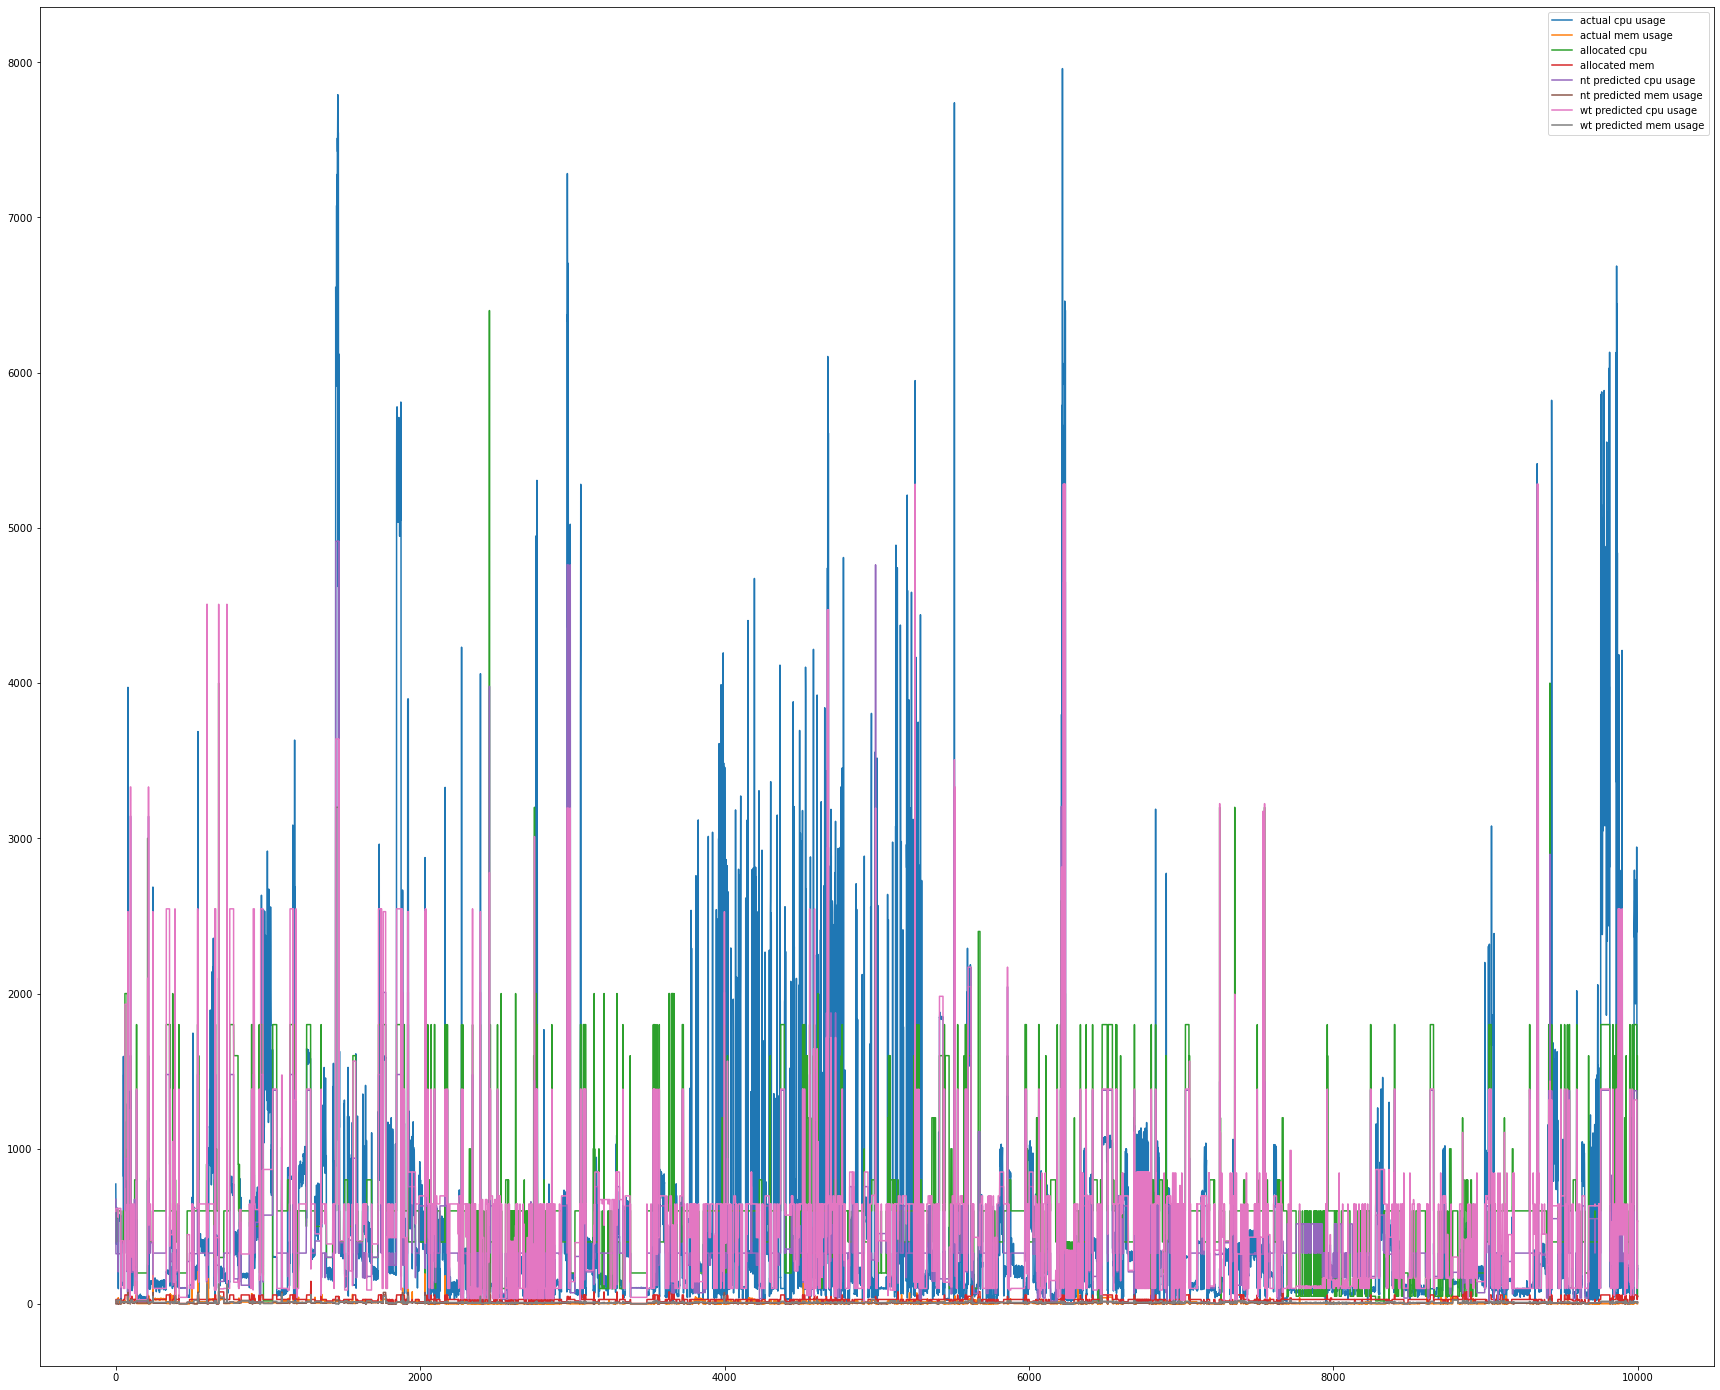

In [11]:
compare_df = pd.DataFrame()
common_columns = ['actual cpu usage', 'actual mem usage', 'allocated cpu', 'allocated mem']
compare_df[common_columns] = no_task_train_prediction_df[common_columns]
comparing_columns = ['predicted cpu usage', 'predicted mem usage']
compare_df[list(map('nt '.__add__, comparing_columns))] = no_task_train_prediction_df[comparing_columns]
compare_df[list(map('wt '.__add__, comparing_columns))] = with_task_train_prediction_df[comparing_columns]
compare_df.plot.line(figsize=(30, 25))

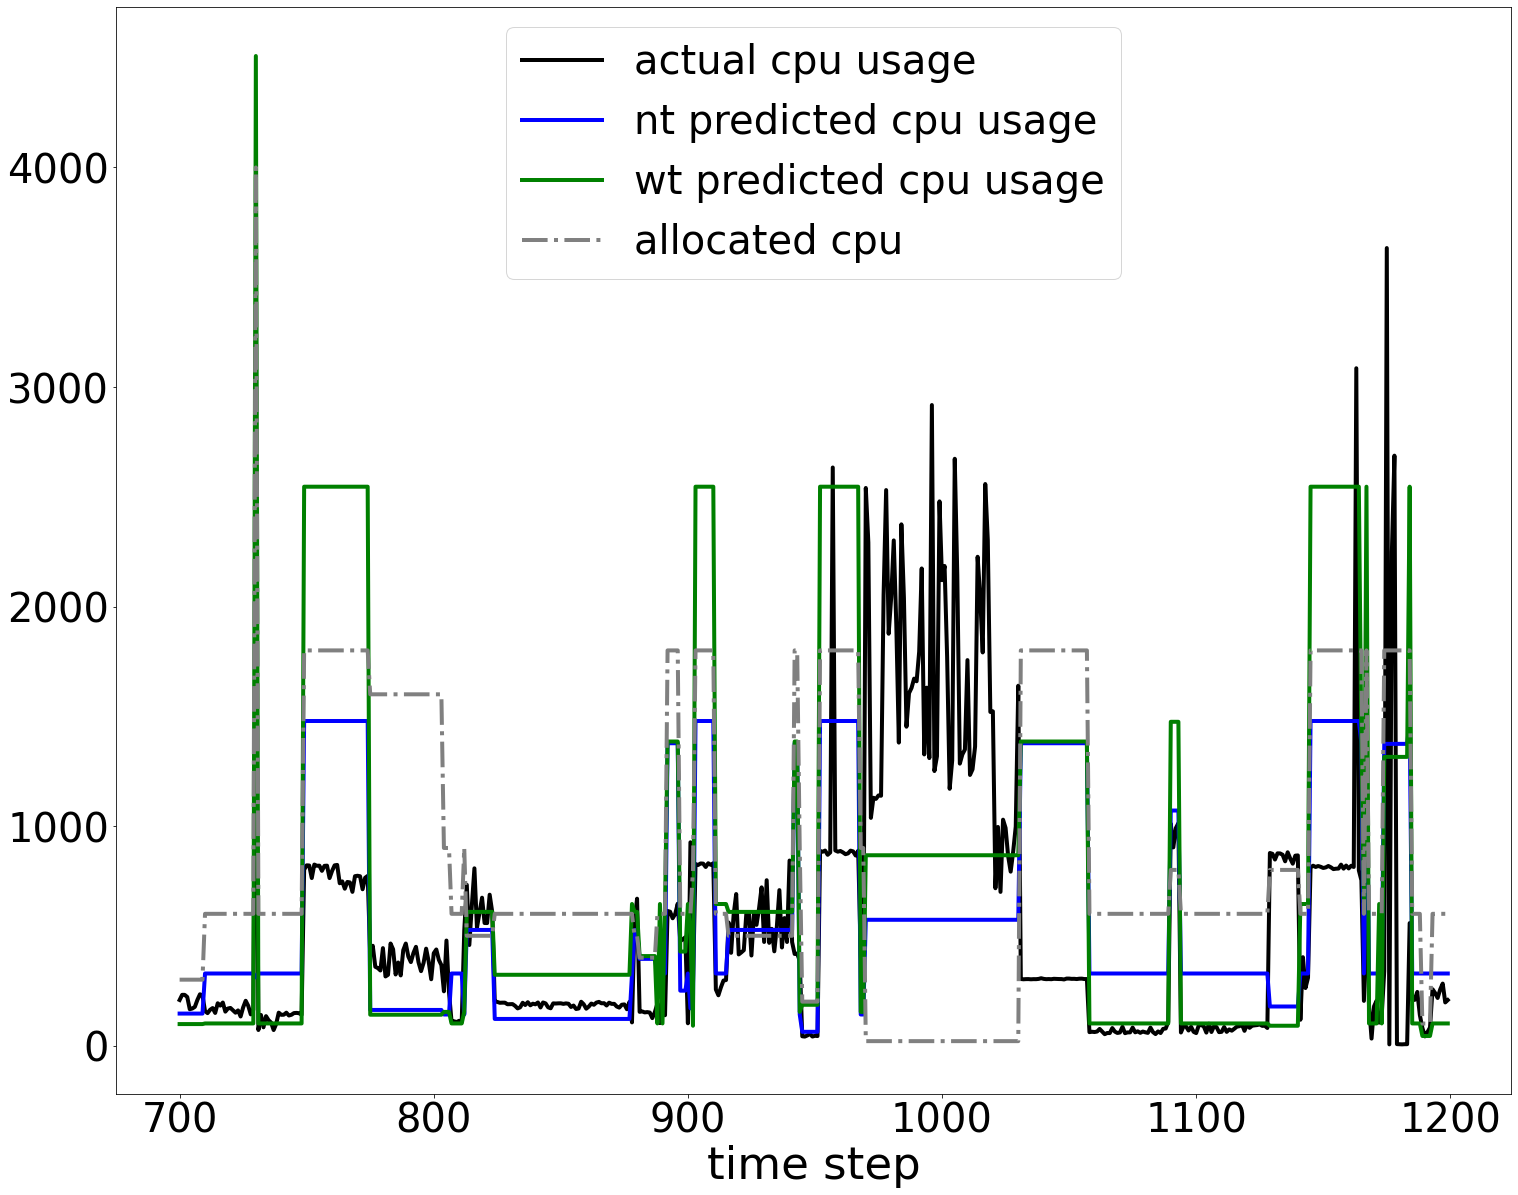

In [12]:
plot_df(compare_df, df_columns=['actual cpu usage', 'nt predicted cpu usage', 'wt predicted cpu usage', 'allocated cpu'], start_range=700, end_range=1200)

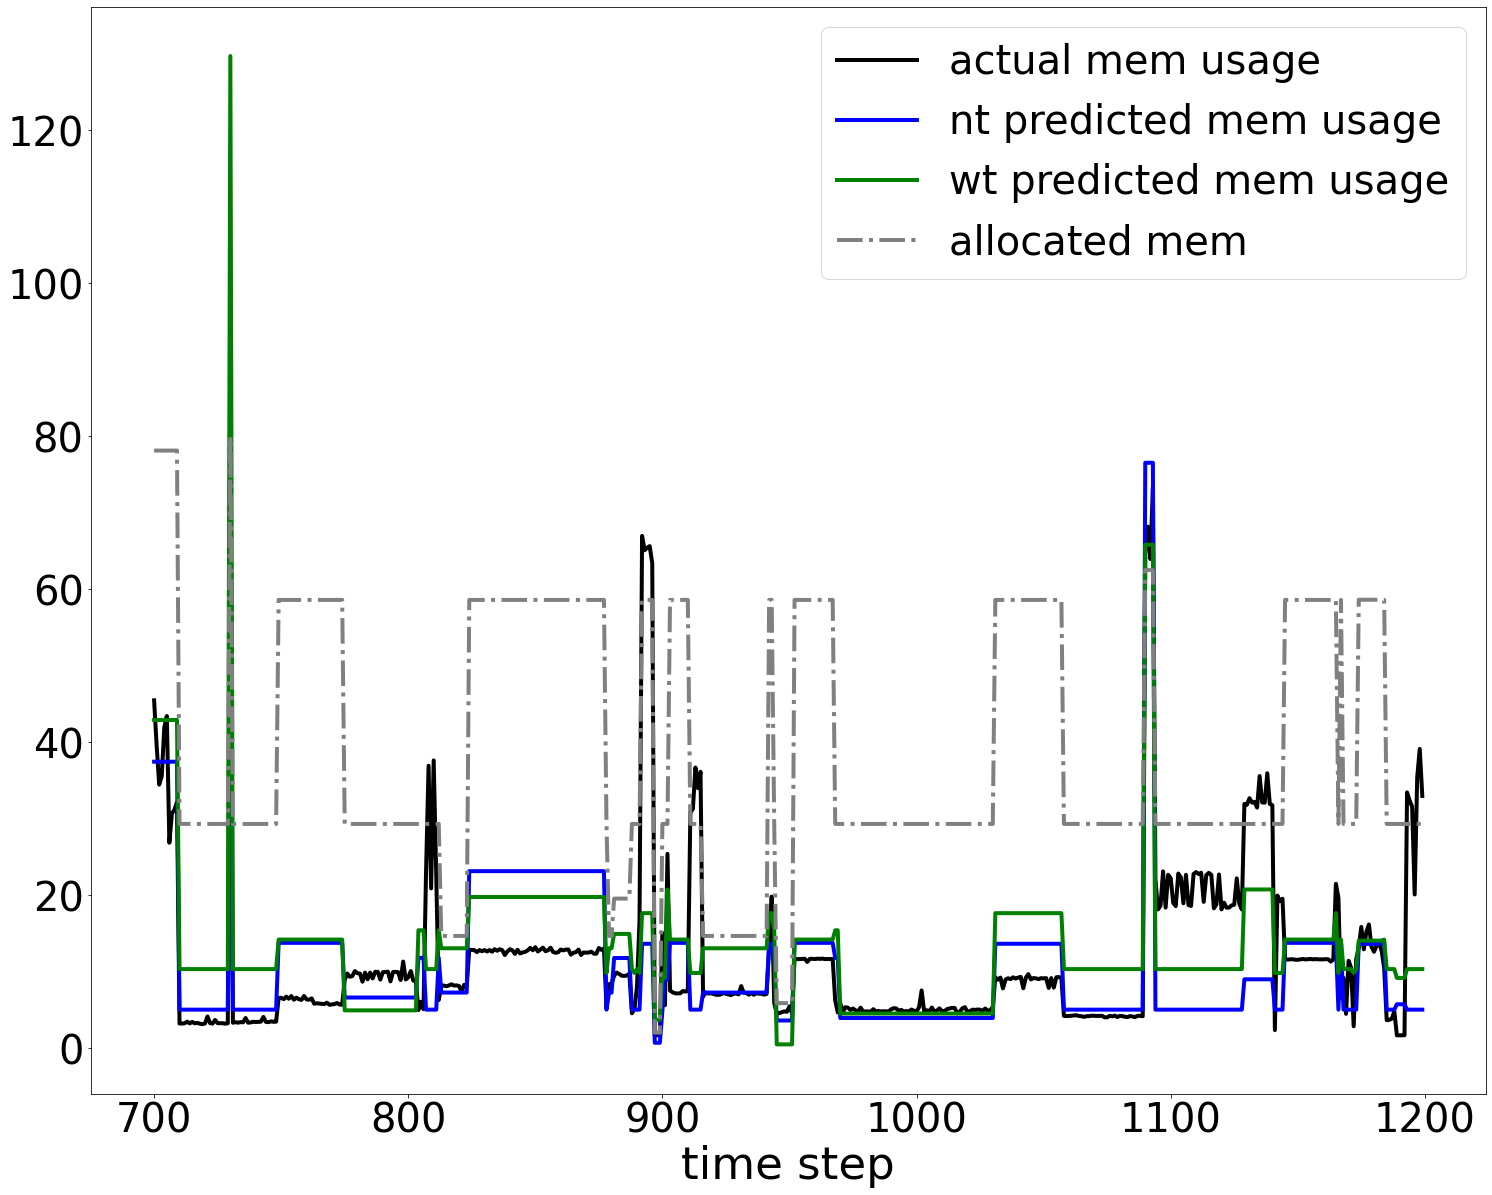

In [13]:
plot_df(compare_df, df_columns=['actual mem usage', 'nt predicted mem usage', 'wt predicted mem usage', 'allocated mem'], start_range=700, end_range=1200)

In [14]:
compare_df.iloc[0]

actual cpu usage          773.050781
actual mem usage           19.953011
allocated cpu             400.000000
allocated mem              10.000002
nt predicted cpu usage    674.911743
nt predicted mem usage      9.447738
wt predicted cpu usage    597.211731
wt predicted mem usage      9.622682
Name: 0, dtype: float64

In [15]:
# test_df = compare_df.iloc[3000:3500, [0, 2, 4, 6]]
test_df = compare_df.iloc[:, [0, 2, 4, 6]]
test_df

,actual cpu usage,allocated cpu,nt predicted cpu usage,wt predicted cpu usage
0,773.050781,400.0,674.911743,597.211731
1,608.671021,600.0,323.875824,616.060181
2,608.102417,600.0,323.875824,616.060181
3,385.129120,600.0,323.875824,616.060181
4,614.094116,600.0,323.875824,616.060181
...,...,...,...,...
9995,255.589432,600.0,328.135406,644.732239
9996,123.900002,600.0,328.135406,100.584679
9997,62.916664,1600.0,162.086319,140.380905
9998,209.150009,50.0,247.156586,535.458984


In [16]:
test_df.iloc[:, 2] / test_df.iloc[:, 0]

0       0.873050
1       0.532103
2       0.532601
3       0.840954
4       0.527404
          ...   
9995    1.283838
9996    2.648389
9997    2.576206
9998    1.181719
9999    1.073770
Length: 10000, dtype: float64

In [17]:
norm_df = pd.DataFrame()
for i in range(1, 4):
    column = test_df.columns[i]
    norm_df[column] = test_df.iloc[:, i] / test_df.iloc[:, 0]


In [18]:
norm_df.head(3)

,allocated cpu,nt predicted cpu usage,wt predicted cpu usage
0,0.517430,0.873050,0.772539
1,0.985754,0.532103,1.012140
2,0.986676,0.532601,1.013086


In [19]:
from typing import List

def get_under_quantile_series(data: pd.Series, quantile: float = 0.99) -> pd.Series:
    q = data.quantile(quantile)
    data = data[data < q]
    
    return data

def get_over_quantile_series(data: pd.Series, quantile: float = 0.99) -> pd.Series:
    q = data.quantile(quantile)
    data = data[data > q]
    
    return data

def get_over_allocated_series(df: pd.DataFrame, column: int, quantile: float = 0.99) -> pd.Series:
    series = df.iloc[:, column].dropna()
    series = series[series >= 1]
    return get_under_quantile_series(series, quantile)

def get_over_allocation_percentage(df: pd.DataFrame, column: int) -> float:
    return round(get_over_allocated_series(df, column).shape[0] / df.shape[0] * 100, ndigits=5)

def get_over_allocated_dataframe(df: pd.DataFrame, columns: List[int], quantile: float = 0.99) -> pd.DataFrame:
    temp_df = pd.DataFrame()
    for col in columns:
        temp_df[df.columns[col]] = get_over_allocated_series(df, col, quantile)
    return temp_df

def describe_over_allocated_dataframe(df: pd.DataFrame, columns: List[int], quantile: float = 0.99) -> pd.DataFrame:
    temp_df = pd.DataFrame()
    for col in columns:
        temp_df[df.columns[col]] = get_over_allocated_series(df, col, quantile).describe()
    return temp_df

def get_under_allocated_series(df: pd.DataFrame, column: int, quantile: float = 0.99) -> pd.Series:
    series = df.iloc[:, column].dropna()
    series = series[series < 1]
    return get_over_quantile_series(series, quantile)

def get_under_allocation_percentage(df: pd.DataFrame, column: int):
    return round(get_under_allocated_series(df, column).shape[0] / df.shape[0] * 100, ndigits=5)

def get_under_allocated_dataframe(df: pd.DataFrame, columns: List[int], quantile: float = 0.99) -> pd.DataFrame:
    temp_df = pd.DataFrame()
    for col in columns:
        temp_df[df.columns[col]] = get_under_allocated_series(df, col, quantile)
    return temp_df

def describe_under_allocated_dataframe(df: pd.DataFrame, columns: List[int], quantile: float = 0.99) -> pd.DataFrame:
    temp_df = pd.DataFrame()
    for col in columns:
        temp_df[df.columns[col]] = get_under_allocated_series(df, col, quantile).describe()
    return temp_df

Source: https://medium.com/@BrendanArtley/matplotlib-color-gradients-21374910584b

In [20]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

# TODO

* Make axis description better
* Start at x axis value 1?
* Add a grid?
* What is density and stacked?

In [21]:
norm_df.iloc[:, 1].quantile(0.95)

9.573148226439988

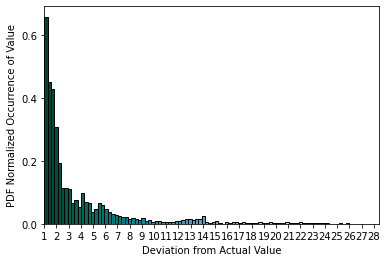

In [22]:
def plot_histogram(data: pd.Series, bin_size: int = 100, save_path: str = '', over_allocation: bool = True, density: bool = True) -> None:
    if over_allocation:
        cm = plt.cm.get_cmap('PuBuGn_r')
    else:
        cm = plt.cm.get_cmap('PuBuGn')
    # cm = plt.cm.get_cmap('YlGnBu_r')
    # plt.cm.PuBuGn_r

    n, bins, patches = plt.hist(data, bin_size, color='green', density=density, stacked=True, edgecolor='black')
    # n, bins, patches = plt.hist(data, bin_size, color='green', stacked=True, density=True, edgecolor='black')
    
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    scale_color = bin_centers - min(bin_centers)
    scale_color /= max(scale_color)

    for c, p in zip(scale_color, patches):
        plt.setp(p, 'facecolor', cm(c))
        
    params = {
        'legend.fontsize': 'x-large',
        'figure.figsize': (20, 15),
        'axes.labelsize': 25,
        'axes.titlesize':25,
        'xtick.labelsize':22,
        'ytick.labelsize':22,
        } 
    plt.rcParams.update(params)


    plt.xlabel('Deviation from Actual Value')
    plt.ylabel('PDF Normalized Occurrence of Value')
    
    if over_allocation:
        plt.xlim([1, data.max()])
        plt.xticks(range(1, int(data.max() + 1)))
    
    if len(save_path) > 0:
        plt.savefig(save_path)
    plt.show()
    

    
plot_histogram(get_over_allocated_series(norm_df, 2))

In [23]:
wt_over_allocation_series = get_over_allocated_series(norm_df, 2, quantile=0.95)
wt_under_allocation_series = get_under_allocated_series(norm_df, 2, quantile=0.05)
print(wt_over_allocation_series.describe().to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &  wt predicted cpu usage \\
\midrule
count &             5896.000000 \\
mean  &                3.202901 \\
std   &                2.750595 \\
min   &                1.000145 \\
25\%   &                1.389376 \\
50\%   &                1.995902 \\
75\%   &                4.119306 \\
max   &               13.914777 \\
\bottomrule
\end{tabular}



/var/folders/dj/hxzphr3j0617vybm1xdwl_tw0000gn/T/ipykernel_58119/488346146.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(wt_over_allocation_series.describe().to_latex(index=True))


In [24]:
print(wt_under_allocation_series.describe().to_latex())

\begin{tabular}{lr}
\toprule
{} &  wt predicted cpu usage \\
\midrule
count &             3603.000000 \\
mean  &                0.624615 \\
std   &                0.220580 \\
min   &                0.222860 \\
25\%   &                0.423697 \\
50\%   &                0.648737 \\
75\%   &                0.804253 \\
max   &                0.999973 \\
\bottomrule
\end{tabular}



/var/folders/dj/hxzphr3j0617vybm1xdwl_tw0000gn/T/ipykernel_58119/3440907117.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(wt_under_allocation_series.describe().to_latex())


In [25]:
asdf = pd.DataFrame()
asdf['wt'] = wt_over_allocation_series
asdf['nt'] = get_over_allocated_series(norm_df, 1, 0.95)
asdf.head()

,wt,nt
1,1.012140,NaN
2,1.013086,NaN
3,1.599620,NaN
4,1.003202,NaN
5,1.042918,NaN


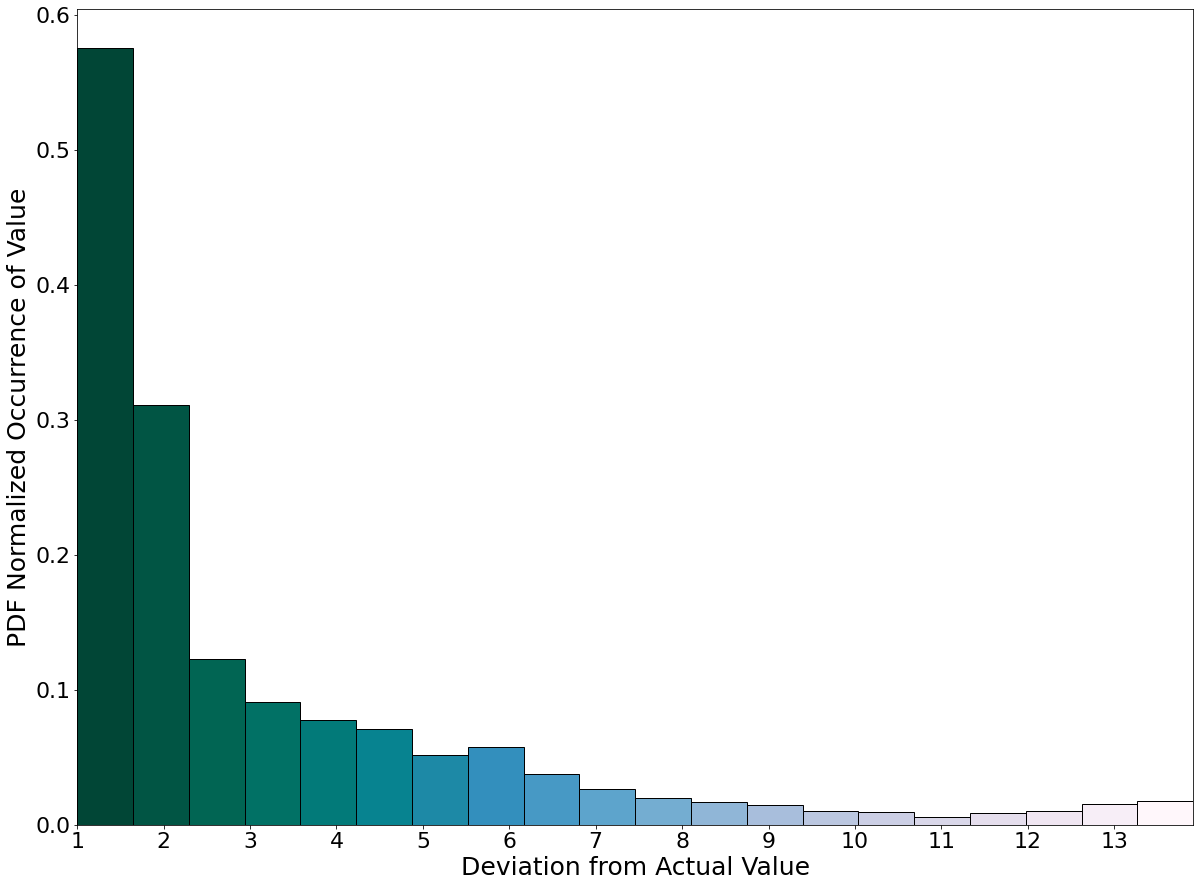

In [26]:

plot_histogram(wt_over_allocation_series, bin_size=20, save_path='wt_over_allocation.png')

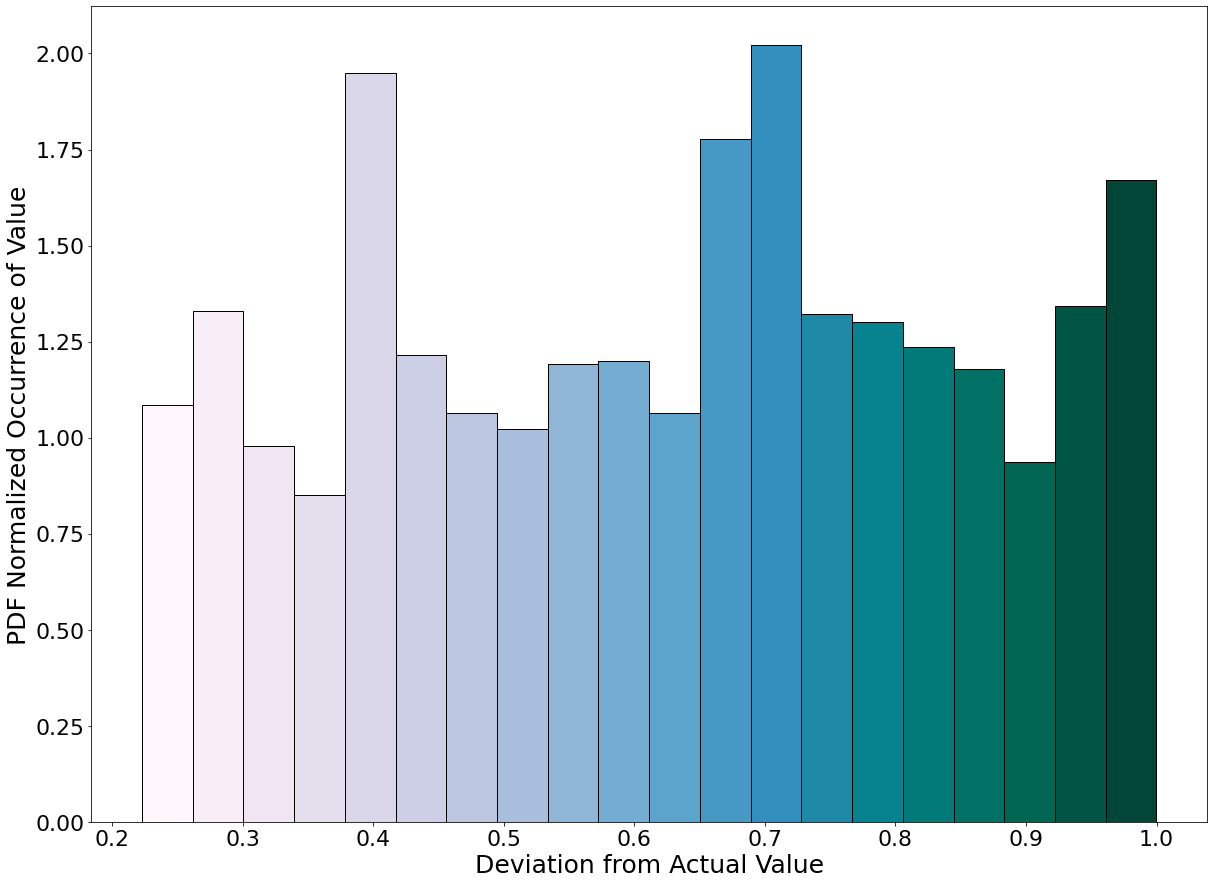

In [27]:
plot_histogram(wt_under_allocation_series, 20, over_allocation=False, density=True)

In [28]:
print(describe_over_allocated_dataframe(norm_df, [0, 1, 2], quantile=0.95).to_latex())
# describe_over_allocated_dataframe(norm_df, [0, 1, 2]).loc[asdf].plot.line(figsize=(20, 15))
# describe_over_allocated_dataframe(norm_df, [0, 1, 2]).plot.line(figsize=(20, 15))

\begin{tabular}{lrrr}
\toprule
{} &  allocated cpu &  nt predicted cpu usage &  wt predicted cpu usage \\
\midrule
count &    6928.000000 &             6196.000000 &             5896.000000 \\
mean  &       4.716589 &                3.117077 &                3.202901 \\
std   &       3.679460 &                2.241624 &                2.750595 \\
min   &       1.000012 &                1.000232 &                1.000145 \\
25\%   &       1.903068 &                1.549565 &                1.389376 \\
50\%   &       3.510183 &                2.374176 &                1.995902 \\
75\%   &       6.204604 &                3.824869 &                4.119306 \\
max   &      18.255046 &               12.907610 &               13.914777 \\
\bottomrule
\end{tabular}



/var/folders/dj/hxzphr3j0617vybm1xdwl_tw0000gn/T/ipykernel_58119/511853515.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(describe_over_allocated_dataframe(norm_df, [0, 1, 2], quantile=0.95).to_latex())


In [29]:
describe_under_allocated_dataframe(norm_df, [0, 1, 2], quantile=0.95)

,allocated cpu,nt predicted cpu usage,wt predicted cpu usage
count,136.000000,174.000000,190.000000
mean,0.969178,0.991962,0.981017
std,0.017522,0.003850,0.010706
min,0.939333,0.985438,0.965672
25%,0.952274,0.988892,0.971146
50%,0.970966,0.991515,0.979748
75%,0.985412,0.994892,0.991973
max,0.999634,0.999922,0.999973


# Description

* What you see (in graph and other)
* How much we defer from real value
* And why we see the difference, and explain because of data, algorithm etc...

In [30]:
get_over_allocated_series(norm_df, 2, thresh).hist(figsize=(15, 10))

NameError: name 'thresh' is not defined

<AxesSubplot:>

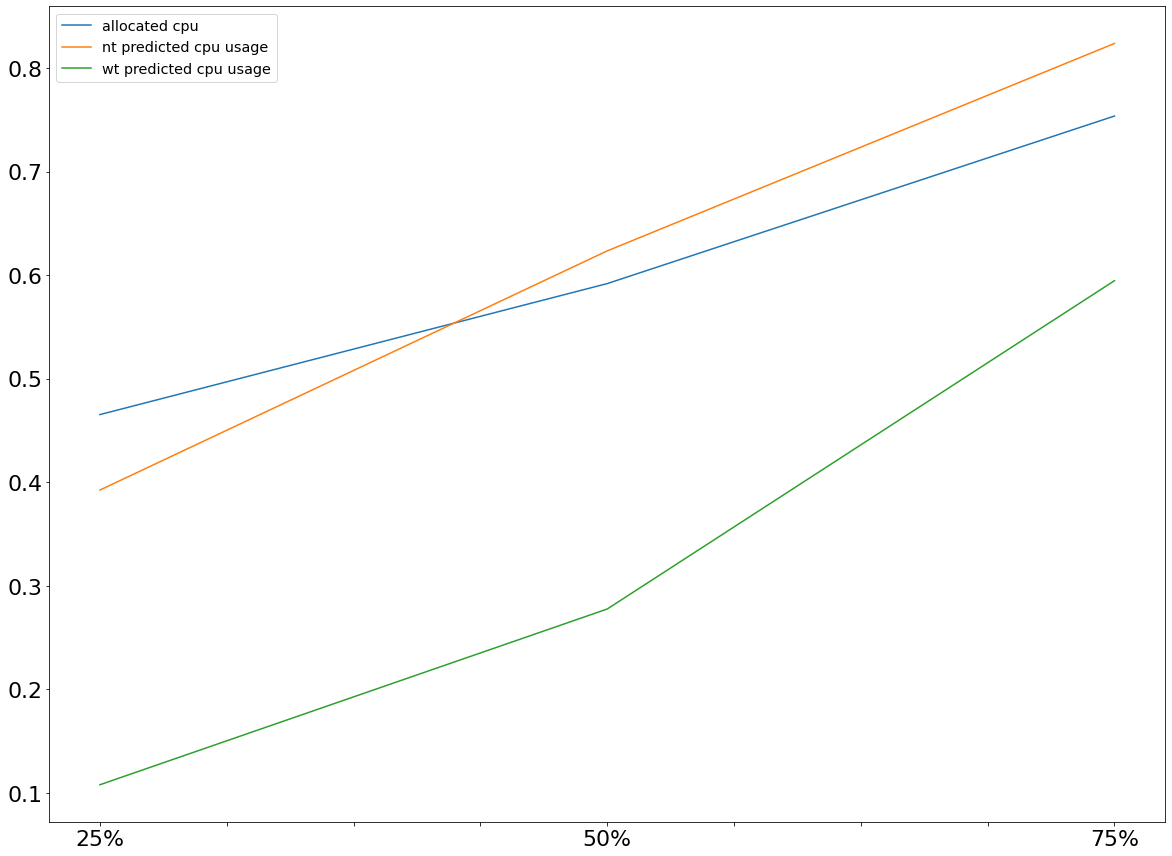

In [ ]:
describe_under_allocated_dataframe(norm_df, [0, 1, 2], thresh).loc[['25%', '50%', '75%']].plot.line()

In [ ]:
get_under_allocated_dataframe(norm_df, [0, 1, 2]).describe()

,allocated cpu,nt predicted cpu usage,wt predicted cpu usage
count,28.000000,0.0,0.0
mean,0.992486,NaN,NaN
std,0.003974,NaN,NaN
min,0.986334,NaN,NaN
25%,0.989020,NaN,NaN
50%,0.992710,NaN,NaN
75%,0.995469,NaN,NaN
max,0.999634,NaN,NaN


In [ ]:
# get_over_allocated_series(norm_df, 0).plot.bar(figsize=(20, 15))
# get_over_allocated_series(norm_df, 2).hist(figsize=(15, 10))

In [ ]:
get_over_allocation_percentage(norm_df, 0)

72.2

In [ ]:
get_under_allocation_percentage(norm_df, 0)

0.28

In [ ]:
get_over_allocation_percentage(norm_df, 2)

48.43

In [ ]:
get_under_allocation_percentage(norm_df, 2)

0.52